## The above code extracts the features of the MEG signals(Brain Waves) using a CNN model

In [5]:
import zipfile

In [9]:
#extracting the dataset
with zipfile.ZipFile("organized_results-20230810T193042Z-001.zip","r") as zip_ref:
    zip_ref.extractall()

In [ ]:
pip install torchsummary

In [4]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 8.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 46.6 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.7/300.7 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 16.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 40.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post7-py3-none-any.whl size=2953 sha256=fad0ffdac0235607fc743f8650b015776f99730f111bf631bbf4ee54f3d6a3ee
  Stored in directory: /home/u115586/.cache/pip/wheels/c8/9c/85/72901eb50bc4bc6e3b2629378d172384ea3dfd19759c77fd2c
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 53.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
# importing the required libraries
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, accuracy_score

# Define the CNN model
class MEG2VEC(nn.Module):
    def __init__(self, num_classes):
        super(MEG2VEC, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) # Adding the Convolution 2d layer
        self.bn1 = nn.BatchNorm2d(32) # Adding a batch normalization layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1) # Adding another Convolution 2d layer
        self.bn2 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 144 * 144, 512)  # 144 = 576 / 2 (due to max pooling)
        self.fc2 = nn.Linear(512, num_classes) # Adding another linear layer
        self.dropout = nn.Dropout(0.1)
    # Defining the forward propagation function
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = x.view(-1, 16 * 144 * 144)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x
# Preparing the dataloader function
def get_data_loaders(data_transforms, batch_size, val_split_ratio=0.2, num_workers=4):
    dataset = datasets.ImageFolder(root="BRAIN/organized_results", transform=data_transforms["train"])
    print(dataset.class_to_idx)
    dataset_size = len(dataset)
    dataset_indices = list(range(dataset_size))
    np.random.shuffle(dataset_indices) # Shuffing the index id's to ensure randomization
    val_split_index = int(np.floor(val_split_ratio * dataset_size))
    train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]

    train_sampler = SubsetRandomSampler(train_idx) # Getting the train sampler
    val_sampler = SubsetRandomSampler(val_idx)  # Getting the test sampler
    # Loading the training data loader
    train_loader = DataLoader(dataset=dataset, shuffle=False, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers) 
    # Loading the testing data loader
    val_loader = DataLoader(dataset=dataset, shuffle=False, batch_size=1, sampler=val_sampler, num_workers=num_workers)

    return train_loader, val_loader

    
# Defining the training function
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad() # Freezing the weights
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward() # Backpropagation
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss / len(train_loader)}")
        
# Evaluating model performance
def evaluate_model(model, val_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_predictions)
    print("Validation Accuracy:", accuracy)
    print("\nClassification Report:\n", classification_report(all_labels, all_predictions))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# preprocessing the training (image) data
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((576, 576)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

batch_size = 4
train_loader, val_loader = get_data_loaders(image_transforms, batch_size)

num_classes = len(train_loader.dataset.classes)
model = MEG2VEC(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, criterion, optimizer, device, num_epochs=20)
evaluate_model(model, val_loader, device)


{'The_Black_Widow': 0, 'cable_spool_fort': 1, 'easy_money': 2, 'lw1': 3}


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20 - Loss: 102.47329723238946
Epoch 2/20 - Loss: 17.161834960872692
Epoch 3/20 - Loss: 3.7287267133698037
Epoch 4/20 - Loss: 3.1207052126167922
Epoch 5/20 - Loss: 1.193242127335667
Epoch 6/20 - Loss: 0.23572280358404138
Epoch 7/20 - Loss: 0.03270813832095274
Epoch 8/20 - Loss: 0.16507467142261056
Epoch 9/20 - Loss: 0.11646324404527753
Epoch 10/20 - Loss: 0.004604484663264685
Epoch 11/20 - Loss: 0.026054607358581228
Epoch 12/20 - Loss: 0.03335053286034917
Epoch 13/20 - Loss: 0.004315683069492193
Epoch 14/20 - Loss: 8.369717160476853e-05
Epoch 15/20 - Loss: 0.664363441193274
Epoch 16/20 - Loss: 0.32344198336002805
Epoch 17/20 - Loss: 0.19265688598401293
Epoch 18/20 - Loss: 0.05997891511177147
Epoch 19/20 - Loss: 0.0011360683233797796
Epoch 20/20 - Loss: 0.0005022343385130857
Validation Accuracy: 0.9230769230769231

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       0.89      0.89 

In [4]:
pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
from torchsummary import summary
model = MEG2VEC(num_classes).to(device)

# Print the summary of the model
summary(model, input_size=(3, 576, 576))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 576, 576]             896
       BatchNorm2d-2         [-1, 32, 576, 576]              64
         MaxPool2d-3         [-1, 32, 288, 288]               0
           Dropout-4         [-1, 32, 288, 288]               0
            Conv2d-5         [-1, 16, 288, 288]           4,624
       BatchNorm2d-6         [-1, 16, 288, 288]              32
         MaxPool2d-7         [-1, 16, 144, 144]               0
           Dropout-8         [-1, 16, 144, 144]               0
            Linear-9                  [-1, 512]     169,869,824
          Dropout-10                  [-1, 512]               0
           Linear-11                    [-1, 4]           2,052
Total params: 169,877,492
Trainable params: 169,877,492
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.80


In [ ]:
weights = model.fc2.weight.data.cpu().numpy()
bias = model.fc2.bias.data.cpu().numpy()

In [ ]:
weights

array([[-0.01227093, -0.02981179,  0.02494627, ...,  0.00725079,
        -0.03682656,  0.03194759],
       [ 0.04022798, -0.01205477, -0.00355153, ...,  0.02733205,
         0.01657236, -0.02817695],
       [-0.02448063,  0.00069862,  0.00521385, ...,  0.0330551 ,
        -0.00564435, -0.03479967],
       [-0.02820493,  0.00582488, -0.01276053, ..., -0.00148993,
         0.00032969, -0.00429593]], dtype=float32)

In [ ]:
weights[0].shape

(512,)

In [ ]:
bias

array([-0.02557549, -0.02215453, -0.03439986, -0.02080782], dtype=float32)

In [ ]:
# Getting the weights of the last hidden layer
final_dict = {
    'The_Black_Widow' : {'weights' : weights[0], 'bias': bias[0]},
    'cable_spool_fort' : {'weights' : weights[1], 'bias': bias[1]},
    'easy_money' : {'weights' : weights[2], 'bias': bias[2]},
    'lw1' : {'weights' : weights[3], 'bias': bias[3]}
}
final_dict

{'The_Black_Widow': {'weights': array([-1.22709302e-02, -2.98117865e-02,  2.49462724e-02,  3.72998156e-02,
          3.52296419e-02,  1.87978297e-02, -1.99429803e-02,  4.43282118e-03,
         -6.60607358e-03, -9.52106342e-03,  2.46799085e-02, -8.09699669e-03,
         -1.55012058e-02, -3.58200632e-02,  1.92401260e-02, -2.02965755e-02,
          3.60615514e-02, -7.07178703e-03,  4.85484162e-03,  3.33212689e-02,
         -5.14385384e-03, -1.43929254e-02,  8.60667415e-03,  2.60700230e-02,
         -2.91506499e-02, -2.12906816e-04, -1.15232766e-02, -1.13538862e-03,
          1.11486623e-02,  1.44722732e-02, -3.58195677e-02,  2.26432830e-02,
          1.02621391e-02, -1.55600412e-02, -4.11107671e-03, -3.05298250e-02,
         -5.39900456e-03, -2.61362121e-02, -1.94731764e-02, -1.05328802e-02,
          2.19454560e-02,  2.07388103e-02,  6.44324953e-03,  2.74211951e-02,
         -8.47680774e-03,  2.34139729e-02, -2.31891833e-02,  1.04600880e-02,
          4.49959934e-02, -2.81937420e-02,  2.

In [ ]:
import pickle

with open('/content/drive/MyDrive/BV/organized_results/stories_data.pkl', 'wb') as f:
    pickle.dump(final_dict, f)

In [ ]:
import os

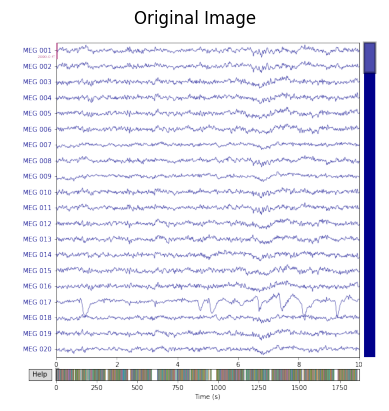

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
# Load an example image and preprocess it
from PIL import Image
from torchvision import transforms

image_path = '/content/drive/MyDrive/BV/organized_results/The_Black_Widow/sub-01_ses-0_task-3.png'
image = Image.open(image_path)
story = image_path.split('/content/drive/MyDrive/BV/organized_results/')
story = story[1].split('/')
story = story[0]

plt.imshow(image)
plt.axis('off')
plt.title('Original Image')
plt.show()

In [ ]:
final_output = output * weights[0] + bias[0]

In [ ]:
# Defining a CNN architecture to retrieve the MEG embeddings
def mv_model(x):
    conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=3, padding=1)
    bn1 = nn.BatchNorm2d(32)
    conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
    bn2 = nn.BatchNorm2d(16)
    pool = nn.MaxPool2d(kernel_size=2, stride=2)
    fc1 = nn.Linear(16 * 144 * 144, 512)
    dropout = nn.Dropout(0.1)

    x = pool(F.relu(bn1(conv1(x))))
    x = dropout(x)
    x = pool(F.relu(bn2(conv2(x))))
    x = dropout(x)
    x = x.view(-1, 16 * 144 * 144)
    x = fc1(x)

    return x
import pickle

# Specify the path to your pickle file
pickle_file_path = '/content/drive/MyDrive/BV/stories_data.pkl'

# Load data from the pickle file
with open(pickle_file_path, 'rb') as f:
    story = pickle.load(f)

# preprocessing the data(image)
preprocess = transforms.Compose([
        transforms.Lambda(lambda img: img.crop((60, 0, 530, img.size[1]))),
        transforms.Resize((576, 576)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5]),

    ])

wave_embeddings = {}

# Path to the folder containing the images
folder_path = "/content/drive/MyDrive/BV/organized_results/"
# Iterate through all files in the folder
for story_name in tqdm(os.listdir(folder_path)):
  wave = []
  file_path = os.path.join(folder_path, story_name)
  for f in tqdm(os.listdir(file_path)):
    img_path = os.path.join(file_path, f)
    image = Image.open(image_path)
    input_tensor = preprocess(image)
    input_tensor = input_tensor.unsqueeze(0)  # Add a batch dimension
    output = mv_model(input_tensor) # Calling the model
    output = output.detach().numpy()
    output = output[0]
    final_output = output * story[story_name]['weights'] + story[story_name]['bias'] # getting the MEG embeddings
    wave.append(final_output)
  wave_embeddings[story_name] = wave



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

In [ ]:
import pickle
#N Saving the MEG embeddings
with open('/content/drive/MyDrive/BV/wave_embeddings.pkl', 'wb') as f:
    pickle.dump(wave_embeddings, f)